In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from copy import deepcopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
import sys
import pickle
import blip_analysis as ba
import exp_blip_models as em
from scipy.cluster.hierarchy import dendrogram, linkage
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe
from scipy.stats import ttest_ind
import importlib
importlib.reload(em)
importlib.reload(ba)

b
b


<module 'blip_analysis' from '/home/camp/warnert/working/Recordings/binary_pulses/blip_analysis/blip_analysis.py'>

In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [4]:
full_models1 = pickle.Unpickler(open('../Fig3/221209_full_models1.pkl', 'rb')).load()
full_models2 = pickle.Unpickler(open('../Fig3/221209_full_models2.pkl', 'rb')).load()
full_models3 = pickle.Unpickler(open('../Fig3/221209_full_models3.pkl', 'rb')).load()

In [5]:
bins1 = np.array([i.opt_out.x[:-1] for i in full_models1])[good_indexes]
bins2 = np.array([i.opt_out.x[:-1] for i in full_models2])[good_indexes]
bins3 = np.array([i.opt_out.x[:-1] for i in full_models3])[good_indexes]
all_bins = np.concatenate([bins1, bins2, bins3], axis=1)
full_max = np.max(np.abs([bins1, bins2, bins3]))



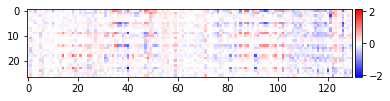

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(all_bins.T, cmap='bwr', vmin=-full_max, vmax=full_max)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
plt.colorbar(im, cax=cax)

In [109]:
link = linkage(all_bins, optimal_ordering=True, method='complete')

In [110]:
Z = dendrogram(link, no_plot=True)

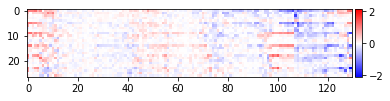

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(all_bins[Z['leaves']].T, cmap='bwr', vmin=-full_max, vmax=full_max)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
plt.colorbar(im, cax=cax)

In [13]:
def plot_bin_heatmap(fig, gs, bins, axhlines=None, sort=True, plot_dendo=True):
    if plot_dendo:
        sub_gridspec = gs.subgridspec(ncols=1, nrows=3, hspace=0)
        dendo_ax = fig.add_subplot(sub_gridspec[0])
        heatmap_ax = fig.add_subplot(sub_gridspec[1:])
        divider = make_axes_locatable(dendo_ax)
        nax = divider.append_axes('right', size='2%', pad=0.05, frameon=False)
        nax.set_yticks([])
        nax.set_xticks([])
        no_plot=False
    else:
        dendo_ax = None
        no_plot=True
        heatmap_ax = fig.add_subplot(gs)
    divider = make_axes_locatable(heatmap_ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    if sort:
        link = linkage(bins, optimal_ordering=True, method='complete')
        Z = dendrogram(link, no_plot=no_plot, ax=dendo_ax)
        bins = bins[Z['leaves']]

    full_max = np.max(np.abs(bins))
    im = heatmap_ax.imshow(bins.T, cmap='bwr', vmin=-full_max, vmax=full_max, aspect='auto')
    plt.colorbar(im, cax=cax)
    if axhlines is not None:
        for axhline in axhlines:
            heatmap_ax.axhline(axhline, color='k', linestyle='--')
    heatmap_ax.set_yticks(range(9*3))
    heatmap_ax.set_ylim(9*3-0.5, -0.5)
    ylabel_base = ['W1', 'W2', 'W3', 'W4', 'W5', 'E2', 'E3', 'E4', 'E5']
    heatmap_ax.set_yticklabels(ylabel_base + ylabel_base + ylabel_base, fontsize=5)
    heatmap_ax.set_ylabel('Weights')
    heatmap_ax.set_xlabel('Units')

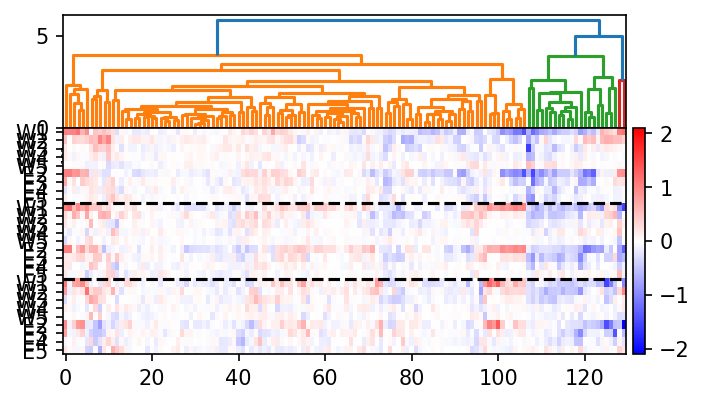

In [7]:
fig = plt.figure(dpi=150, figsize=(5, 3))
gs = GridSpec(1, 1)

plot_bin_heatmap(fig,gs[0], all_bins, axhlines=[8.5, 17.5], plot_dendo=True)

In [7]:
pca1 = PCA(n_components=9)
pcad1 = pca1.fit_transform(bins1)
pca2 = PCA(n_components=9)
pcad2 = pca2.fit_transform(bins2)
pca3 = PCA(n_components=9)
pcad3 = pca3.fit_transform(bins3)
pca_all = PCA(n_components=9)
pcad_all = pca_all.fit_transform(np.concatenate([bins1, bins2, bins3], axis=0))

In [9]:
all_pcad_conc = np.concatenate([pcad1, pcad2, pcad3], axis=1)
print(all_pcad_conc.shape)

(130, 27)


In [ ]:
def plot_

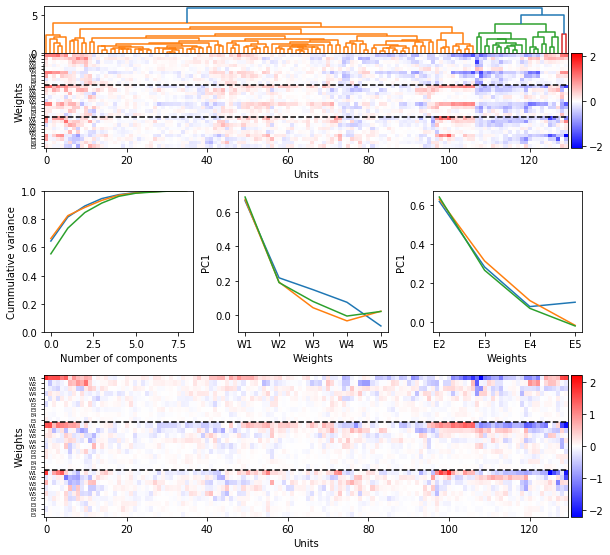

In [20]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(4, 3, right=0.95, left=0.05, top=0.95, hspace=0.3, wspace=0.3)
plot_bin_heatmap(fig, gs[0, :], all_bins, axhlines=[8.5, 17.5])
pca_var_ax = fig.add_subplot(gs[1, 0])
pca_var_ax.plot(np.cumsum(pca1.explained_variance_ratio_))
pca_var_ax.plot(np.cumsum(pca2.explained_variance_ratio_))
pca_var_ax.plot(np.cumsum(pca3.explained_variance_ratio_))
pca_var_ax.set_xlabel('Number of components')
pca_var_ax.set_ylabel('Cummulative variance')
pca_var_ax.set_ylim(0, 1)
pca_time_ax = fig.add_subplot(gs[1, 1])
pca_time_ax.plot(pca1.components_[0, :5]*-1)
pca_time_ax.plot(pca2.components_[0, :5]*-1)
pca_time_ax.plot(pca3.components_[0, :5]*-1)
pca_time_ax.set_ylabel('PC1')
pca_time_ax.set_xlabel('Weights')
pca_time_ax.set_xticks(range(5))
pca_time_ax.set_xticklabels(["W1", 'W2', 'W3', 'W4', "W5"])


pca_onset_ax = fig.add_subplot(gs[1, 2])
pca_onset_ax.plot(pca1.components_[0, 5:]*-1)
pca_onset_ax.plot(pca2.components_[0, 5:]*-1)
pca_onset_ax.plot(pca3.components_[0, 5:]*-1)
pca_onset_ax.set_ylabel('PC1')
pca_onset_ax.set_xlabel('Weights')
pca_onset_ax.set_xticks(range(4))
pca_onset_ax.set_xticklabels(['E2', 'E3', 'E4', "E5"])



plot_bin_heatmap(fig, gs[2, :], -all_pcad_conc, axhlines=[8.5, 17.5], plot_dendo=False)